# Générateur de Noms de Domaine avec LLM
## Expérimentations et Évaluations Systématiques

Ce notebook présente le développement itératif d'un système de génération de noms de domaine utilisant des modèles de langage, avec un focus sur l'évaluation automatisée et la découverte de cas limites.

## 1. Configuration et Imports

In [1]:
import sys
import os
sys.path.append("..")
import numpy as np
import collections
from datetime import datetime
import matplotlib.pyplot as plt

# Import des modules du projet
from src.creation_dataset import CreationDataset
from src.generateur_nom_domaine import GenerateurNomsDomaine
from src.utils import charger_json


print(f"Date de l'expérience: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Date de l'expérience: 2025-08-02 19:40:39


## 2. Création du Dataset Synthétique

Nous commençons par créer un dataset synthétique diversifié pour l'évaluation.

In [2]:
# Initialiser le créateur de dataset
creation_dataset = CreationDataset()

# Créer le dataset complet
print("Création du dataset synthétique...")
chemin_dataset = creation_dataset.sauvegarder_dataset("dataset_experimental.json")

# Charger et analyser le dataset créé
dataset_complet = charger_json(chemin_dataset)

print(f"Dataset créé avec succès:")
print(f"   - Exemples d'entraînement: {len(dataset_complet['entrainement'])}")
print(f"   - Cas limites: {len(dataset_complet['cas_limites'])}")

# Visualisation de la distribution des types de business
descriptions = [ex['description_business'] for ex in dataset_complet['entrainement']]
print(f"\nExemples de descriptions générées:")
for i, desc in enumerate(descriptions[:5]):
    print(f"   {i+1}. {desc}")

INFO:src.utils:Génération d'un dataset de 800 exemples...
INFO:src.utils:Généré 100/800 exemples
INFO:src.utils:Généré 200/800 exemples
INFO:src.utils:Généré 300/800 exemples
INFO:src.utils:Généré 400/800 exemples
INFO:src.utils:Généré 500/800 exemples
INFO:src.utils:Généré 600/800 exemples
INFO:src.utils:Généré 700/800 exemples
INFO:src.utils:Généré 800/800 exemples
INFO:src.utils:Données sauvegardées dans ../data/dataset_experimental.json
INFO:src.utils:Dataset complet sauvegardé: ../data/dataset_experimental.json
INFO:src.utils:Données chargées depuis ../data/dataset_experimental.json


Création du dataset synthétique...
Dataset créé avec succès:
   - Exemples d'entraînement: 800
   - Cas limites: 14

Exemples de descriptions générées:
   1. Service de beauté via vente
   2. cabinet comptabilité dans chez le client
   3. Nouveau café bio à centre-ville
   4. Service de vêtements via commerce
   5. Service de beauté via boutique abordable


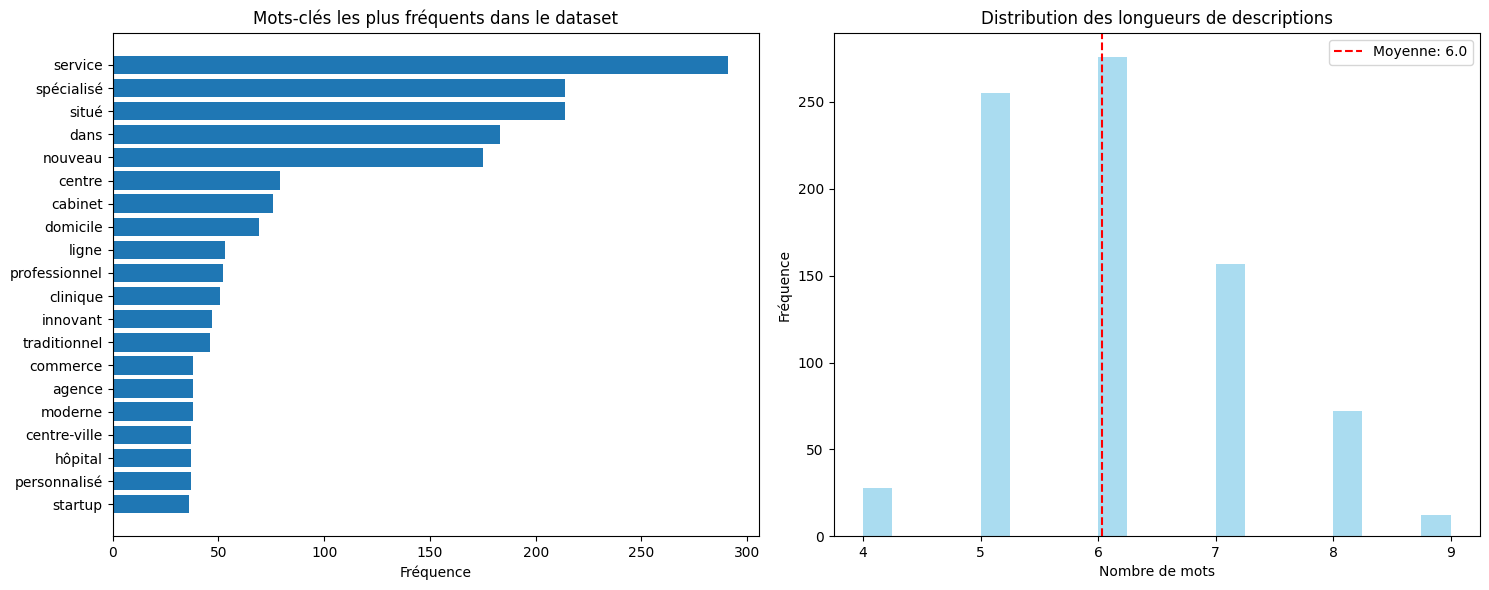

Statistiques du dataset:
   - Longueur moyenne des descriptions: 6.0 mots
   - Longueur médiane: 6.0 mots
   - Vocabulaire unique: 90 mots


In [3]:
# Analyser les mots-clés les plus fréquents
tous_mots = []
for desc in descriptions:
    mots = desc.lower().split()
    tous_mots.extend([mot for mot in mots if len(mot) > 3])

mots_frequents = collections.Counter(tous_mots).most_common(20)

# Créer une visualisation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Graphique des mots les plus fréquents
mots, freq = zip(*mots_frequents)
ax1.barh(range(len(mots)), freq)
ax1.set_yticks(range(len(mots)))
ax1.set_yticklabels(mots)
ax1.set_xlabel('Fréquence')
ax1.set_title('Mots-clés les plus fréquents dans le dataset')
ax1.invert_yaxis()

# Distribution des longueurs de descriptions
longueurs = [len(desc.split()) for desc in descriptions]
ax2.hist(longueurs, bins=20, alpha=0.7, color='skyblue')
ax2.set_xlabel('Nombre de mots')
ax2.set_ylabel('Fréquence')
ax2.set_title('Distribution des longueurs de descriptions')
ax2.axvline(np.mean(longueurs), color='red', linestyle='--', label=f'Moyenne: {np.mean(longueurs):.1f}')
ax2.legend()

plt.tight_layout()
plt.show()

print(f"Statistiques du dataset:")
print(f"   - Longueur moyenne des descriptions: {np.mean(longueurs):.1f} mots")
print(f"   - Longueur médiane: {np.median(longueurs):.1f} mots")
print(f"   - Vocabulaire unique: {len(set(tous_mots))} mots")

## 3. Initialisation du Modèle Générateur

Configuration et test initial du générateur basé sur Llama3.1

In [4]:
# Initialiser le générateur de base
print("Initialisation du générateur de noms de domaine...")
try:
    generateur = GenerateurNomsDomaine(model="llama3.1", garde_fous=True, garde_fous_use_llm=False)
    info_modele = generateur.obtenir_info_modele()
    
    print("Générateur initialisé avec succès")
    print(f"   - Modèle: {info_modele['nom_modele']}")
    print(f"   - URL de base: {info_modele['base_url']}")
    print(f"   - Garde-fous activés: {info_modele['garde_fous_actifs']}")
    print(f"   - Styles disponibles: {', '.join(info_modele['styles_disponibles'])}")
    
except Exception as e:
    print(f"Erreur lors de l'initialisation: {e}")
    print("Vérifiez qu'Ollama est en cours d'exécution et que le modèle llama3.1 est téléchargé")
    print("   Commandes à exécuter:")
    print("   - ollama serve")
    print("   - ollama pull llama3.1")

INFO:src.utils:Modèle llama3.1 initialisé avec succès


Initialisation du générateur de noms de domaine...
Générateur initialisé avec succès
   - Modèle: llama3.1
   - URL de base: http://localhost:11434
   - Garde-fous activés: True
   - Styles disponibles: professionnel, creatif, moderne, classique, court


In [5]:
# Test initial avec des exemples variés
descriptions_test = [
    "restaurant italien familial avec terrasse en centre-ville",
    "startup de développement d'applications mobiles innovantes",
    "cabinet de conseil en marketing digital pour PME",
    "boutique de vêtements bio et éthiques en ligne",
    "école de formation en intelligence artificielle"
]

print("Tests initiaux du générateur baseline...\n")

resultats_baseline = []

for i, description in enumerate(descriptions_test, 1):
    print(f"Test {i}/5: {description}")
    
    try:
        resultat = generateur.generer_suggestions(
            description_business=description,
            nombre_suggestions=3,
            style="professionnel"
        )
        
        if resultat["status"] == "success":
            print("Suggestions générées:")
            for suggestion in resultat["suggestions"]:
                print(f"   - {suggestion['domaine']} (confiance: {suggestion['confidence']})")
            print(f"   Durée: {resultat['metadata']['duree_generation_sec']}s\n")
            
            resultats_baseline.append({
                "description": description,
                "resultats": resultat
            })
        else:
            print(f"Échec: {resultat.get('message', 'Erreur inconnue')}\n")
            
    except Exception as e:
        print(f"Erreur: {e}\n")

print(f"Tests baseline terminés: {len(resultats_baseline)}/{len(descriptions_test)} réussis")

INFO:src.utils:Génération de 3 | suggestions pour: restaurant italien familial avec terrasse en centr...


Tests initiaux du générateur baseline...

Test 1/5: restaurant italien familial avec terrasse en centre-ville


INFO:httpx:HTTP Request: POST http://localhost:11434/api/generate "HTTP/1.1 200 OK"
INFO:src.utils:Génération terminée: 3 suggestions créées
INFO:src.utils:Génération de 3 | suggestions pour: startup de développement d'applications mobiles in...


Suggestions générées:
   - bellavita.fr (confiance: 0.9)
   - taverneitalienne.com (confiance: 0.7)
   - lacasadellafamiglia.net (confiance: 0.6)
   Durée: 50.29s

Test 2/5: startup de développement d'applications mobiles innovantes


INFO:httpx:HTTP Request: POST http://localhost:11434/api/generate "HTTP/1.1 200 OK"
INFO:src.utils:Génération terminée: 3 suggestions créées
INFO:src.utils:Génération de 3 | suggestions pour: cabinet de conseil en marketing digital pour PME...


Suggestions générées:
   - appliinnov.com (confiance: 0.9)
   - mobizen.net (confiance: 0.8)
   - savoirmobile.org (confiance: 0.8)
   Durée: 41.89s

Test 3/5: cabinet de conseil en marketing digital pour PME


INFO:httpx:HTTP Request: POST http://localhost:11434/api/generate "HTTP/1.1 200 OK"
INFO:src.utils:Génération terminée: 3 suggestions créées
INFO:src.utils:Génération de 3 | suggestions pour: boutique de vêtements bio et éthiques en ligne...


Suggestions générées:
   - pmepro.fr (confiance: 0.9)
   - mediamerge.net (confiance: 0.8)
   - digitaliaconsulting.com (confiance: 0.7)
   Durée: 46.73s

Test 4/5: boutique de vêtements bio et éthiques en ligne


INFO:httpx:HTTP Request: POST http://localhost:11434/api/generate "HTTP/1.1 200 OK"
INFO:src.utils:Génération terminée: 3 suggestions créées
INFO:src.utils:Génération de 3 | suggestions pour: école de formation en intelligence artificielle...


Suggestions générées:
   - bioethiquemode.com (confiance: 0.9)
   - vivreenvert.fr (confiance: 0.9)
   - modepourlemonde.org (confiance: 0.8)
   Durée: 47.66s

Test 5/5: école de formation en intelligence artificielle


INFO:httpx:HTTP Request: POST http://localhost:11434/api/generate "HTTP/1.1 200 OK"
INFO:src.utils:Génération terminée: 2 suggestions créées


Suggestions générées:
   - intelliform.fr (confiance: 0.9)
   - iaedu.com (confiance: 0.8)
   Durée: 43.8s

Tests baseline terminés: 5/5 réussis
